# Modelos de clasificación

## Classification Machine Learning models

Los modelos de clasificación tienen como objetivo predecir en qué grupo o clase debemos clasificar a un individuo. Es decir, la variable dependiente es **discreta**. A diferencia de los modelos de regresión cuyo objetivo era predecir el valor exacto, ya que su variable dependiente era **continua**

Las variables independientes pueden ser tanto continuas como discretas.

En los modelos de clasificación las métricas usadas para calcular cómo de bueno es nuestro modelo se basan en contabilizar cuántos individuos han sido bien o mal clasificados en cada una de las clases (Accuracy, Precisión, Potencia, F-Score, sensibilidad y especificidad).

Los modelos de clasificación pueden ser **binomiales**, con dos categorías en la variable dependiente, o **multinomiales**, con 3 ó más grupos en la variable dependiente.

Existen multitud de modelos diferentes para clasificar individuos, entre ellos Árboles de decisión, Regresión Logística...



## Árboles de decisión

https://www.youtube.com/watch?v=_L39rN6gz7Y

Es un sistema de modelado de datos que divide y subdivide el dataframe varias veces, en función de cómo discriminan las clases de la variable dependiente.

In [ ]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

from scipy.special import expit

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn import tree

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
aprende = pd.read_csv('aprende.txt', sep = ';')
aprende

,id,escucha,comparte_pantalla,aprende
0,1,1,1,1
1,2,1,0,0
2,3,1,1,1
3,4,1,0,0
4,5,1,1,1
5,6,0,0,0
6,7,1,1,1
7,8,0,0,0
8,9,1,1,1
9,10,0,0,0


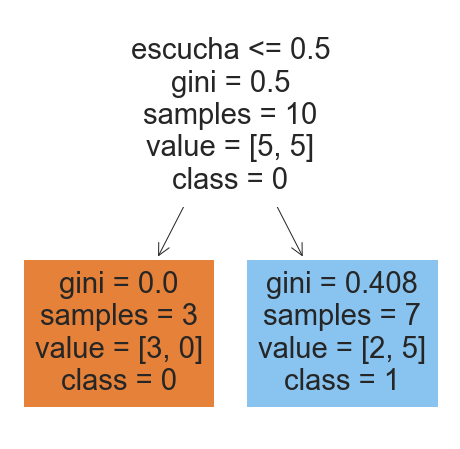

In [ ]:
classifier_DT = tree.DecisionTreeClassifier(max_depth = 3)
classifier_DT = classifier_DT.fit(aprende[['escucha']], aprende['aprende'])

fig = plt.figure(figsize=(8,8))
_ = tree.plot_tree(classifier_DT,
                   feature_names=['escucha'],
                   class_names=np.unique(aprende['aprende']).astype(str),
                   filled=True)

Hemos construido un árbol usando como variable clasificadora **escucha**, vemos los resultados:

En el **nodo raíz**, el primero de más arriba, tenemos que:

 - Va a hacer una división en torno al escucha <= 0.5, es decir, como la variable escucha toma 0 y 1, los ceros van a la izquierda y los unos a la derecha
 - que de todas las observaciones el 50% corresponden a cada una de las clases (Gini)
 - Tenemos 10 observaciones
 - 5 alumnos son aprende = 0 (No) y otros 5 son aprende = 1 (Sí)


En los **nodos del segundo nivel** tenemos que:

 - 3 observaciones van para un lado y 7 para el otro
 - en el de la izda 3 pertenecen a la clase 0, y ninguno a la clase 1. Tenemos una impureza de 0 (Gini)
 - en el de la drcha tenemos 2 pertenecientes  a la clase 0 y 5 a la clase 1. Impureza = 0.408
 - Como tal, los 3 estudiantes del nodo izquierdo serán clasificados como 0 (No aprenden), y los 7 de la derecha serán clasificados como 1 (Sí aprenden)

Conclusión, de los alumnos que no escuchan todos ellos no aprenden, pero de los que sí escuchan la clasificación no es tan buena, ya que se dirá que aprenden los 7, pero 2 de ellos no lo habrán hecho


Probamos ahora con la variable **comparte_pantalla**, a ver qué tal clasifica

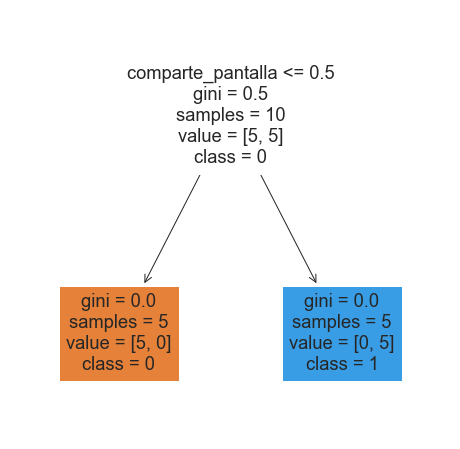

In [ ]:
classifier_DT = tree.DecisionTreeClassifier(max_depth = 3)
classifier_DT = classifier_DT.fit(aprende[['comparte_pantalla']], aprende['aprende'])

fig = plt.figure(figsize=(8,8))
_ = tree.plot_tree(classifier_DT,
                   feature_names=['comparte_pantalla'],
                   class_names=np.unique(aprende['aprende']).astype(str),
                   filled=True)

El nodo raíz es similar al anterior, ya que es el inicial

- Ambos nodos tienen impureza cero, es decir, separan perfectamente a los alumnos que aprenden de los que no aprenden
- La variable comparte_pantalla podemos considerarla una buena variable predictora de aprende.

Conclusión los alumnos que **comparten pantalla y escriben código a diario sí aprenden**, los que no lo hacen no aprenden

## Impureza de Gini

*No confundir con el coeficiente de GINI

Gini es el indicador que nos dice cómo de buena o mala es la división que hacen los árboles de decisión.

Esta división es por líneas, por individuos de nuestro dataset. Se hace a partir de una variable. Si nuestras observaciones en dicha variable toman un valor mayor que el punto de corte que estamos utilizando van hacia una rama del árbol de decisión, si es menor van hacia la otra.

Lo que nos indica Gini es cómo de mezcladas están las clases de la variable dependiente usando esa división. Gini toma valores entre 0 y 0.5, cuanto más bajo mejor discrimina.

Otra forma de verlo es considerando el Gini como un **índice de impureza**, cuanto más bajo más puro, siendo que cero significa que todas las observaciones que caen en cada una de las ramas son de la misma catagoría de la variable dependiente. Cuando Gini es próximo a 0.5 quiere decir que en esa rama tenemos 50/50 de la variable target.


Gini es calculado para todas las variables al inicio de cada nivel del árbol, la que tenga el valor más pequeño será la variable a usar como divisora de los datos

In [4]:
stroke = pd.read_csv('/content/drive/MyDrive/USC Upstate/IronHack/Prework/DATA/data/Stroke.txt', sep = ';')
stroke.head()

,Id,Blood Pressure,Obesity,Sex,Stroke
0,1,H,Y,M,N
1,2,L,Y,M,Y
2,3,H,N,F,Y
3,4,N,Y,F,Y
4,5,H,Y,F,Y


In [5]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              130 non-null    int64 
 1   Blood Pressure  130 non-null    object
 2   Obesity         130 non-null    object
 3   Sex             130 non-null    object
 4   Stroke          130 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.2+ KB


In [7]:
# label encoder custom
#dictionary
blood={'H': 0, 'N': 1, 'L': 2}
obesity={'Y': 1, 'N': 0}
sex={'M': 1, 'F': 0}
stroke_attack={'Y': 1, 'N': 0}

def encode(dic, x):
    return dic[x]

stroke['Blood2']=stroke['Blood Pressure'].apply(lambda x: blood[x])
stroke['obesity2']=stroke['Obesity'].apply(lambda x: obesity[x])
stroke['sex2']=stroke['Sex'].apply(lambda x: sex[x])
stroke['stroke_attack']=stroke['Stroke'].apply(lambda x: stroke_attack[x])

stroke.head()

,Id,Blood Pressure,Obesity,Sex,Stroke,Blood2,obesity2,sex2,stroke_attack
0,1,H,Y,M,N,0,1,1,0
1,2,L,Y,M,Y,2,1,1,1
2,3,H,N,F,Y,0,0,0,1
3,4,N,Y,F,Y,1,1,0,1
4,5,H,Y,F,Y,0,1,0,1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(stroke[['Blood2','obesity2','sex2']],
                                                    stroke['stroke_attack'], train_size = 0.8, random_state = 0)


In [9]:
print(X_train.shape)
print(X_test.shape)

(104, 3)
(26, 3)


In [10]:
print(X_train.groupby('Blood2')['Blood2'].count())
print(X_train.groupby('obesity2')['obesity2'].count())
print(X_train.groupby('sex2')['sex2'].count())

Blood2
0    31
1    40
2    33
Name: Blood2, dtype: int64
obesity2
0    51
1    53
Name: obesity2, dtype: int64
sex2
0    56
1    48
Name: sex2, dtype: int64


In [11]:
classifier_DT = tree.DecisionTreeClassifier(max_depth = 3)
classifier_DT = classifier_DT.fit(X_train, y_train)
classifier_DT.feature_importances_

array([0.68510434, 0.30753542, 0.00736024])

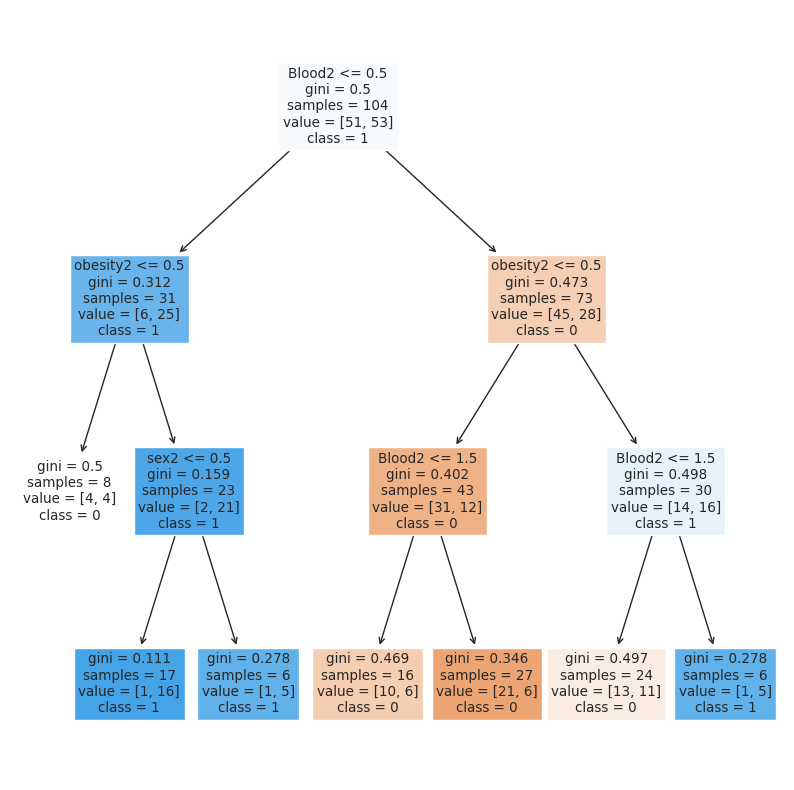

In [12]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(classifier_DT,
                   feature_names=['Blood2','obesity2','sex2'],
                   class_names=np.unique(y_test).astype(str),
                   filled=True)

In [13]:
classifier_DT.predict(X_test)


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0])

In [14]:
print("Train set score (Accuracy) =", classifier_DT.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", classifier_DT.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, classifier_DT.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Stroke No','pred Stroke Yes'], showindex = ['real Stroke No','real Stroke Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, classifier_DT.predict(X_test)))

Train set score (Accuracy) = 0.7115
Test set score (Accuracy) = 0.5769
╒═════════════════╤══════════════════╤═══════════════════╕
│                 │   pred Stroke No │   pred Stroke Yes │
╞═════════════════╪══════════════════╪═══════════════════╡
│ real Stroke No  │               11 │                 0 │
├─────────────────┼──────────────────┼───────────────────┤
│ real Stroke Yes │               11 │                 4 │
╘═════════════════╧══════════════════╧═══════════════════╛
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        11
           1       1.00      0.27      0.42        15

    accuracy                           0.58        26
   macro avg       0.75      0.63      0.54        26
weighted avg       0.79      0.58      0.52        26



In [15]:
prec=7/(7+5)
pot = 7/(4+7)

fscore = 2*(prec*pot)/(prec+pot)
fscore

0.6086956521739131

## Matriz de confusión

https://www.youtube.com/watch?v=Kdsp6soqA7o


La matriz de confusión resume todos los casos de nuestra prueba de validación, indicando cuántos fueron bien y mal clasificados, y también nos permite analizar si nuestro modelo clasifica bien para cada una de las categorías.


In [16]:
print(tabulate([['TN',  'FP'],[ 'FN',  'TP']],headers = ['pred -','pred +'], showindex = ['real -','real +'], tablefmt = 'fancy_grid'))


╒════════╤══════════╤══════════╕
│        │ pred -   │ pred +   │
╞════════╪══════════╪══════════╡
│ real - │ TN       │ FP       │
├────────┼──────────┼──────────┤
│ real + │ FN       │ TP       │
╘════════╧══════════╧══════════╛


## Métricas de eficiencia del modelo de clasificación

https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5#:~:text=A%20confusion%20matrix%20is%20a%20tabular%20summary%20of,performance%20metrics%20like%20accuracy%2C%20precision%2C%20recall%2C%20and%20F1-score.

### Accuracy

Es la proporción de observaciones clasificadas correctamente

$$ TP + TN $$ $$ ------ $$ $$ TP + FP + TN + FN $$

Es el indicador más general y en el primero en el que tenemos que fijarnos

### Precisión

Es la proporción de clasificaciones positivas correctas sobre el total de clasificaciones positivas.
De todos los clasificados como 1, ¿Cuántos realmente lo eran?

$$ TP $$ $$ ------ $$ $$ TP + FP $$

Este indicador queremos optimizarlo cuando nos interesa que las predicciones de una de las clases sea especialmente correcta, sin importarnos errar en la otra.

Por ejemplo, en la clasificación de los email Spam,

### Potencia (Recall)

Es la proporción de verdaderos positivos clasificados como tal.
De todos los positivos, ¿Cuántos mi modelo ha clasificado como tal?

$$ TP $$ $$ ------ $$ $$ TP + FN $$

Este indicador lo optimizamos cuando una clase es especialmente sensible y no queremos dejar sin clasificar correctamente ninguno de sus individuos


### F-Score

Es una métrica que combina la Precisión y la Potencia


$$ 2 * (Precision * Recall) $$ $$ ------ $$ $$ (Precision + Recall) $$

Nos permite calibrar un modelo teniendo en cuenta tanto la precisión como la potencia

## Cuándo optimizar precisión o potencia

En modelos de detección de enfermedades, como cuando se hacen **pruebas de diagnóstico**, bajo ningún concepto quieres clasificar a un paciente como no-enfermo, es preferible clasificar un sano como enfermo. Es decir, queremos reducir a toda costa el ratio de Falsos negativos. Esto se consigue **optimizando la Potencia**

En un modelo de **detección de spam** sería muy perjudicial dar un Falso positivo, es decir, marcar un email como spam cuando realmente es importante. Más vale que se cuele algún spam en la bandeja de entrada principal que al revés. Esto se consigue **optimizando la precisión**

En la práctica es muy importante entender bien el problema que se está intentando resolver/clasificar, y a partir de ahí buscar qué métrica se quiere analizar.

La accuracy nos da una visión general que es buena e importante, pero no suficiente, **siempre se deben analizar varias de las métricas de las que disponemos**

## Random Forest

https://www.youtube.com/watch?v=J4Wdy0Wc_xQ

https://www.quantstart.com/articles/bootstrap-aggregation-random-forests-and-boosted-trees/


El algoritmo **Random Forest**, como su propio nombre indica, utiliza un conjunto de árboles para clasificar las observaciones.

La idea es generar **varios árboles** (varios modelos), pero cuando tenemos un nuevo individuo y queremos clasificarlo, con qué árbol nos quedamos? Cuál es la clasificación correcta?

El nuevo individuo será pasado por todos los árboles que conforman el bosque, cada uno de ellos dará un veredicto y clasificará esta nueva observación como clase 1 ó 0. Después se hará una **votación**, la clase que más haya sido escogida por los árboles en su conjunto será la decisión final del algoritmo.


Por otro lado se le llama **Random** porque vamos a seleccionar en cada nivel de cada árbol un conjunto de variables a testar/introducir aleatoriamente (**Feature Bagging**).

También serán seleccionadas aleatoriamente una serie de observaciones, con reemplazamiento, o sea habrá posiblemente observaciones en el conjunto de entrenamiento que salgan repetidas y otras que no salgan. Esto se hace para aumentar el conjunto de entrenamiento.

https://immune.institute/blog/metodos-de-bagging-y-de-boosting-diferencia/

![image.png](attachment:image.png)

In [26]:
dolphins = pd.read_csv('/content/drive/MyDrive/USC Upstate/IronHack/Prework/DATA/data/Dolphnis.txt', sep = ';')
dolphins.head(3)

,Id,Length,Gills,Beak,Teeth,Dolphin
0,1,3,Y,Y,F,Y
1,2,3,N,N,F,Y
2,3,3,N,N,F,Y


In [18]:
dolphins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       271 non-null    int64 
 1   Length   271 non-null    int64 
 2   Gills    271 non-null    object
 3   Beak     271 non-null    object
 4   Teeth    271 non-null    object
 5   Dolphin  271 non-null    object
dtypes: int64(2), object(4)
memory usage: 12.8+ KB


In [19]:
Gills={'Y': 1, 'N': 0}
Beak={'Y': 1, 'N': 0}
Teeth={'M': 1, 'F': 0}
Dolphin={'Y': 1, 'N': 0}

def encode(dic, x):
    return dic[x]

dolphins['Gills2']=dolphins['Gills'].apply(lambda x: Gills[x])
dolphins['Beak2']=dolphins['Beak'].apply(lambda x: Beak[x])
dolphins['Teeth2']=dolphins['Teeth'].apply(lambda x: Teeth[x])
dolphins['Dolphin2']=dolphins['Dolphin'].apply(lambda x: Dolphin[x])
dolphins

,Id,Length,Gills,Beak,Teeth,Dolphin,Gills2,Beak2,Teeth2,Dolphin2
0,1,3,Y,Y,F,Y,1,1,0,1
1,2,3,N,N,F,Y,0,0,0,1
2,3,3,N,N,F,Y,0,0,0,1
3,4,3,Y,Y,F,Y,1,1,0,1
4,5,3,N,Y,F,Y,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
266,267,3,Y,Y,F,Y,1,1,0,1
267,268,4,Y,N,F,Y,1,0,0,1
268,269,3,Y,Y,F,Y,1,1,0,1
269,270,4,Y,Y,F,Y,1,1,0,1


In [20]:
dolphins.groupby('Dolphin2')['Dolphin2'].count()

Dolphin2
0    117
1    154
Name: Dolphin2, dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dolphins[['Gills2','Beak2','Teeth2','Length']],
                                                    dolphins['Dolphin2'], train_size = 0.60, random_state = 0)
X_test.shape

(109, 4)

In [22]:
rf_clf = RandomForestClassifier(n_estimators = 3, criterion ='gini') #  criterion ='entropy'
rf_clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=3)

In [23]:
y_predict = rf_clf.predict(X_test)
y_predict

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0])

In [24]:
print("Train set score (Accuracy) =", rf_clf.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", rf_clf.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, rf_clf.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Dolphin No','pred Dolphin Yes'], showindex = ['real Dolphin No','real Dolphin Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, rf_clf.predict(X_test)))

Train set score (Accuracy) = 0.8148
Test set score (Accuracy) = 0.7982
╒══════════════════╤═══════════════════╤════════════════════╕
│                  │   pred Dolphin No │   pred Dolphin Yes │
╞══════════════════╪═══════════════════╪════════════════════╡
│ real Dolphin No  │                40 │                 10 │
├──────────────────┼───────────────────┼────────────────────┤
│ real Dolphin Yes │                12 │                 47 │
╘══════════════════╧═══════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.77      0.80      0.78        50
           1       0.82      0.80      0.81        59

    accuracy                           0.80       109
   macro avg       0.80      0.80      0.80       109
weighted avg       0.80      0.80      0.80       109



## Regresión Logística

https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe

https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica

https://datascientest.com/es/que-es-la-regresion-logistica

La regresión logística es un modelo estadístico para estudiar las relaciones entre un conjunto de **variables X** y una **variable cualitativa Y**. Se trata de un modelo lineal generalizado que utiliza una función logística como función de enlace.

Un modelo de regresión logística permite predecir la **probabilidad de que ocurra un evento** (valor de 1) o no (valor de 0) a partir de la optimización de los coeficientes de regresión. Este resultado siempre varía entre 0 y 1. Cuando el valor predicho supera un umbral(normalmente 0.5), es probable que ocurra el evento, mientras que cuando ese valor está por debajo del mismo umbral, no es así.

También se puede definir como una función que busca predecir la clase a la que pertenece un individuo del cual sólo conocemos parte de su información, la relativa a sus variables independientes.



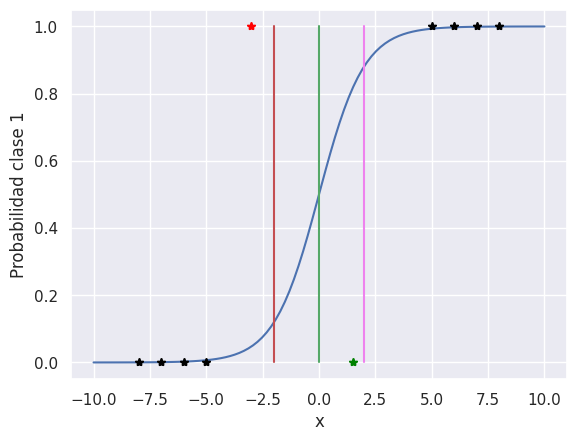

In [25]:
#define range of x-values
x = np.linspace(-10, 10, 100)

#calculate sigmoid function for each x-value
y = expit(x)

#create plot
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('Probabilidad clase 1')

plt.plot([-2,-2], [0, 1], color='r')
plt.plot([0,0], [0, 1], color='g')
plt.plot([2,2], [0, 1], color='violet')

plt.plot([-5,-5], [0, 0], marker = '*', color='black')
plt.plot([-6,-6], [0, 0], marker = '*', color='black')
plt.plot([-7,-7], [0, 0], marker = '*', color='black')
plt.plot([-8,-8], [0, 0], marker = '*', color='black')
plt.plot([-3,-3], [1, 1], marker = '*', color='red')

plt.plot([1.5,1.5], [0, 0], marker = '*', color='green')
plt.plot([5,5], [1, 1], marker = '*', color='black')
plt.plot([6,6], [1, 1], marker = '*', color='black')
plt.plot([7,7], [1, 1], marker = '*', color='black')
plt.plot([8,8], [1, 1], marker = '*', color='black')

#display plot
plt.show()

Cuando la variable independiente X toma el valor -2, la probabilidad de pertencer a la clase 1 es casi igual a 0. Cuando X toma el valor 2 la probabilidad del individuo pertenecer a la clase 1 es muy alta.

El punto rojo tiene características de la clase 0, por eso su probabilidad de ser clase 1 es tan baja, no obstante en la realidad es clase 1, en definitiva estaría mal clasificado para cualquier punto de corte propuesto. El punto verde estaría solo bien clasificado usando el punto de corte morado. Contrariamente al rojo, tiene características de clase 1 a pesar de ser clase 0.


La regresión logística se ajusta los datos a través de una función sigmoide.

Para definir qué función sigmoide es la más idónea, vamos a tratar de optimizar los coeficientes Beta

![image.png](attachment:image.png)

### Regresion logística con Python

https://realpython.com/logistic-regression-python/

In [27]:
df = pd.read_csv('/content/sample_data/Spotify.csv')
df.columns

FileNotFoundError: ignored

In [ ]:
df.groupby('hit')['hit'].count()

hit
0    20333
1    20496
Name: hit, dtype: int64

In [ ]:
X = df.drop(columns='hit').drop(columns=['id','track','artist','uri'])
y = df['hit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[['danceability','energy','loudness']], y, train_size = 0.8, random_state=42)


In [ ]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model_LR.intercept_

array([0.19896023])

In [ ]:
model_LR.coef_

array([[ 3.91858158, -1.23590741,  0.15967818]])

In [ ]:
model_LR.predict(X_train)

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
print("Train set score (Accuracy) =", model_LR.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", model_LR.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Hit No','pred Hit Yes'], showindex = ['real Hit No','real Hit Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR.predict(X_test)))

Train set score (Accuracy) = 0.6699
Test set score (Accuracy) = 0.6754
╒══════════════╤═══════════════╤════════════════╕
│              │   pred Hit No │   pred Hit Yes │
╞══════════════╪═══════════════╪════════════════╡
│ real Hit No  │          2584 │           1497 │
├──────────────┼───────────────┼────────────────┤
│ real Hit Yes │          1154 │           2931 │
╘══════════════╧═══════════════╧════════════════╛
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      4081
           1       0.66      0.72      0.69      4085

    accuracy                           0.68      8166
   macro avg       0.68      0.68      0.67      8166
weighted avg       0.68      0.68      0.67      8166



## Otro ejemplo

In [28]:
cancer = pd.read_csv('/content/drive/MyDrive/USC Upstate/IronHack/Prework/DATA/data/breast_cancer.txt', sep = ';')
cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [29]:
cancer['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [30]:
diagnosis={'M': 1, 'B': 0}

def encode(dic, x):
    return dic[x]

cancer['diagnosis2']=cancer['diagnosis'].apply(lambda x: diagnosis[x])

In [32]:
X = cancer.drop(columns=['id','diagnosis'])
X = cancer[['smoothness_mean','compactness_mean']] # Solo realizamos el modelo con dos variables independientes
y = cancer['diagnosis2']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)


In [33]:
y_test

204    0
70     1
131    1
431    0
540    0
      ..
486    0
75     1
249    0
238    0
265    1
Name: diagnosis2, Length: 114, dtype: int64

In [34]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

print(model_LR.intercept_)
print(model_LR.coef_)

[-1.15717582]
[[0.85635674 5.21828998]]


In [35]:
model_LR.predict(X_train)[0:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
print("Train set score (Accuracy) =", model_LR.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", model_LR.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR.predict(X_test))
print(tabulate(conf_mat,headers = ['pred cancer No','pred cancer Yes'], showindex = ['real cancer No','real cancer Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR.predict(X_test)))

Train set score (Accuracy) = 0.6681
Test set score (Accuracy) = 0.6842
╒═════════════════╤══════════════════╤═══════════════════╕
│                 │   pred cancer No │   pred cancer Yes │
╞═════════════════╪══════════════════╪═══════════════════╡
│ real cancer No  │               71 │                 0 │
├─────────────────┼──────────────────┼───────────────────┤
│ real cancer Yes │               36 │                 7 │
╘═════════════════╧══════════════════╧═══════════════════╛
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        71
           1       1.00      0.16      0.28        43

    accuracy                           0.68       114
   macro avg       0.83      0.58      0.54       114
weighted avg       0.79      0.68      0.60       114



In [37]:
cancer.groupby('diagnosis2')['diagnosis2'].count()

diagnosis2
0    357
1    212
Name: diagnosis2, dtype: int64

<Axes: xlabel='diagnosis2', ylabel='Count'>

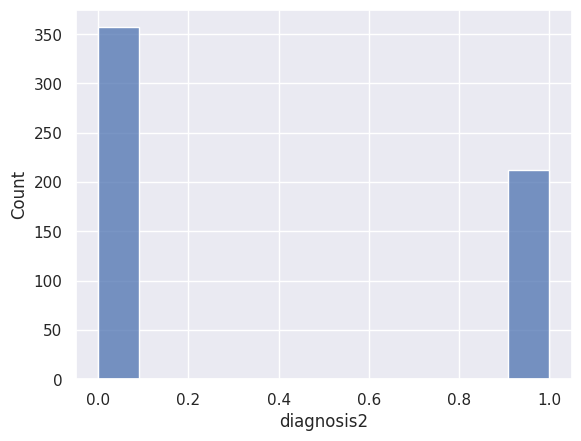

In [38]:
sns.histplot(cancer.diagnosis2)

## Modelos de clasificación desbalanceados

En el mundo real pocas son las ocasiones en las que las categorías de nuestra variable dependiente están balanceadas, esto quiere decir que la **variable dependiente no tiene la misma frecuencia en sus dos catagorías**.


Hay que prestar especial atención a esto ya que el modelo puede clasificar mal aparentando que lo hace bien. Como acabamos de ver, el algoritmo es muy listo y sabe que clasificando todo 0 va a tener una buena accuracy, así que "no se la juega"


Por eso es tan importante hacer un buen **análisis de datos y conocer bien la distribución de nuestras variables**

Existen varias formas de corregir esta situación de desbalanceo: oversampling y undersampling.

El **oversampling** consiste en repetir/duplicar observaciones de la clase menos frecuente hasta conseguir una proporción de al menos 40/60


El **undersampling** consiste en eliminar observaciones de la clase mayoritaria hasta igualar con la otra (al menos 40/60).

También se puede hacer una combinación de ambas.

Es importante tener en cuenta que solo aplicaremos la técnica de Oversampling o Undersampling a los **datos de entrenamiento**, los datos de test no se tocan.


Nuestro desbalanceo aquí es de un 30/70, pero es habitual encontrarse un 10/90 o incluso 1/99

Cómo solucionarlo??
https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037

### Over Sampling

- Random Oversampling: Con esta técnica el algoritmo genera datos nuevos de forma aleatoria basándose en los datos que le pasamos, hasta igualar ambas clases.


In [39]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)


In [40]:
y_train_ros.value_counts()

0    286
1    286
Name: diagnosis2, dtype: int64

<Axes: xlabel='diagnosis2', ylabel='Count'>

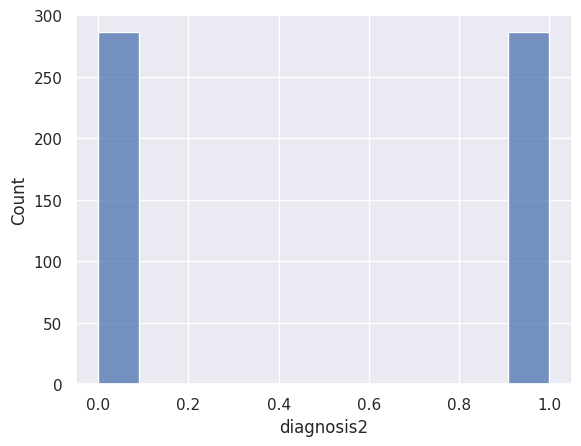

In [41]:
sns.histplot(y_train_ros)

In [42]:
model_LR_ros = LogisticRegression()
model_LR_ros.fit(X_train_ros, y_train_ros)

print(model_LR_ros.intercept_)
print(model_LR_ros.coef_)

[-0.80405137]
[[1.0444569  6.35140046]]


In [43]:
print("Train set score (Accuracy) =", model_LR_ros.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", model_LR_ros.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_ros.predict(X_test))
print(tabulate(conf_mat,headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real iagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_ros.predict(X_test)))

Train set score (Accuracy) = 0.7934
Test set score (Accuracy) = 0.7807
╒══════════════════╤════════════════════╤════════════════════╕
│                  │   pred diagnosis B │   pred diagnosis M │
╞══════════════════╪════════════════════╪════════════════════╡
│ real iagnosis B  │                 58 │                 13 │
├──────────────────┼────────────────────┼────────────────────┤
│ real diagnosis M │                 12 │                 31 │
╘══════════════════╧════════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.70      0.72      0.71        43

    accuracy                           0.78       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.78      0.78      0.78       114



### Oversampling SMOTE


- Smote: Este método es similar con la salvedad de que los datos generados de forma aleatoria se generan siguiendo una distribución normal.

In [44]:
smote = SMOTE()

In [45]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [46]:
y_train_sm.value_counts()

0    286
1    286
Name: diagnosis2, dtype: int64

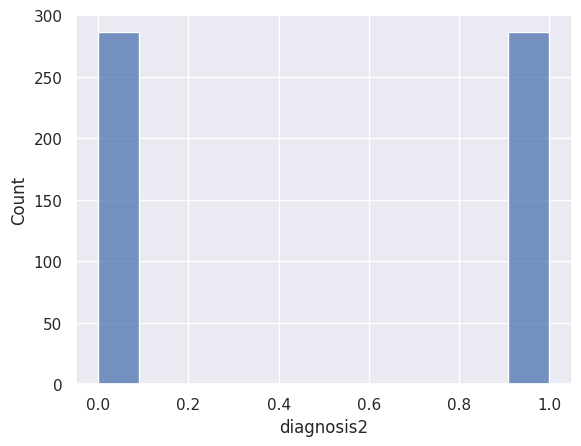

In [47]:
sns.histplot(y_train_sm);

In [48]:
model_LR_sm = LogisticRegression()
model_LR_sm.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [49]:
model_LR_sm.intercept_

array([-0.80200506])

In [50]:
model_LR_sm.coef_

array([[1.03253555, 6.331244  ]])

In [51]:
model_LR_sm.predict(X_test)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1])

In [52]:
print("Train set score (Accuracy) =", model_LR_sm.score(X_train_sm, y_train_sm).round(4))
print("Test set score (Accuracy) =", model_LR_sm.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_sm.predict(X_test))
print(tabulate(conf_mat, headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real iagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_sm.predict(X_test)))

Train set score (Accuracy) = 0.7762
Test set score (Accuracy) = 0.7807
╒══════════════════╤════════════════════╤════════════════════╕
│                  │   pred diagnosis B │   pred diagnosis M │
╞══════════════════╪════════════════════╪════════════════════╡
│ real iagnosis B  │                 58 │                 13 │
├──────────────────┼────────────────────┼────────────────────┤
│ real diagnosis M │                 12 │                 31 │
╘══════════════════╧════════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.70      0.72      0.71        43

    accuracy                           0.78       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.78      0.78      0.78       114



### Undersampling

Undersampling elimina aleatoriamente observaciones de la clase mayoritaria hasta igualar con la minoritaria


In [53]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

[(0, 169), (1, 169)]


In [54]:
y_train_rus.value_counts()

0    169
1    169
Name: diagnosis2, dtype: int64

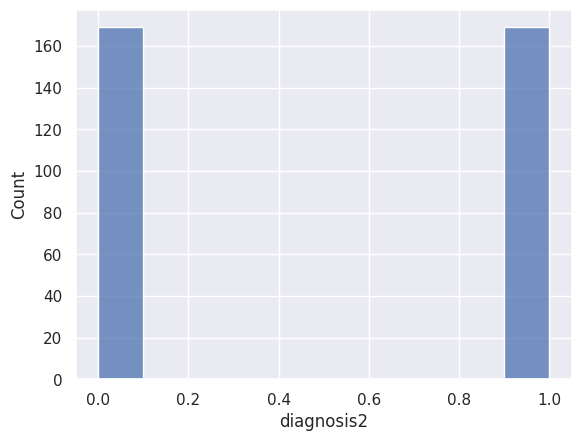

In [55]:
sns.histplot(y_train_rus);

In [56]:
model_LR_rus = LogisticRegression()
model_LR_rus.fit(X_train_rus, y_train_rus)

LogisticRegression()

In [57]:
model_LR_rus.intercept_

array([-0.5577551])

In [58]:
model_LR_rus.coef_

array([[0.70294376, 4.40107778]])

In [59]:
model_LR_rus.predict(X_test)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1])

In [60]:
print("Train set score (Accuracy) =", model_LR_rus.score(X_train_rus, y_train_rus).round(4))
print("Test set score (Accuracy) =", model_LR_rus.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_rus.predict(X_test))
print(tabulate(conf_mat,headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real iagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_rus.predict(X_test)))

Train set score (Accuracy) = 0.7811
Test set score (Accuracy) = 0.7807
╒══════════════════╤════════════════════╤════════════════════╕
│                  │   pred diagnosis B │   pred diagnosis M │
╞══════════════════╪════════════════════╪════════════════════╡
│ real iagnosis B  │                 58 │                 13 │
├──────────────────┼────────────────────┼────────────────────┤
│ real diagnosis M │                 12 │                 31 │
╘══════════════════╧════════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.70      0.72      0.71        43

    accuracy                           0.78       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.78      0.78      0.78       114



## Validación Cruzada (Cross Validation)

https://1library.co/article/validaci%C3%B3n-cruzada-aprendizaje-por-retro-propagaci%C3%B3n-de-errores.zxnrp7oq

https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada


https://tech.gobetech.com/53557/como-se-aplica-la-validacion-cruzada-a-la-regresion-logistica-quiero-evaluar-la-precision-de-un-modelo-de-regresion-logistica-en-un-conjunto-de-datos.html#:~:text=El%20%C3%A1rea%20bajo%20la%20curva%20ROC%20es%20una,y%20odds%20ratio%20de%20una%20variable%20explicativa%20continua%29.

----------------

Es un método de **selección entre un modelo y otro**. Esta técnica es usada tanto en los modelos de clasificación como de regresión.

Se basa en **dividir el conjunto de entrenamiento en K partes**. Se van a hacer en total K iteraciones, en cada una de ellas vamos a entrenar el modelo con K-1 subpartes y la última será usada como test.

La utilidad final de la valdiación cruzada es calcular K métricas (accuracy o la que más nos interese según nuestro problema) y **calcular la media de dichas métricas**. Este cálculo se realiza en 2 ó más **modelos que queramos comparar**, aquel modelo que tenga una mayor accuracy será considerado mejor que el otro.

Cuando hablamos de dos modelos diferentes puede ser porque usemos un algoritmo diferente (Random Forest vs Regresión Logística) o el mismo algoritmo pero con diferentes variables independientes

In [62]:
model_LR_rus = LogisticRegression()
model_LR_rus.fit(X_train_rus, y_train_rus)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model_LR_rus, X_train_rus, y_train_rus, scoring='accuracy', cv=cv, n_jobs=-1)
acc_LR_mean = np.mean(n_scores).round(4)
acc_LR_var = np.var(n_scores).round(4)
print("accuracy media entre los 10 modelos:", acc_LR_mean)

accuracy media entre los 10 modelos: 0.7781


In [63]:
result_RF_rus = RandomForestClassifier(n_estimators = 16, criterion ='gini')
result_RF_rus.fit(X_train_rus,y_train_rus)

result_RF_rus = result_RF_rus.fit(X_train_rus, y_train_rus)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(result_RF_rus, X_train_rus, y_train_rus, scoring='accuracy', cv=cv, n_jobs=-1)
acc_RF_mean = np.mean(n_scores).round(4)
acc_RF_var = np.var(n_scores).round(4)
print("accuracy media entre los 10 modelos:", acc_RF_mean)

accuracy media entre los 10 modelos: 0.7667


En este caso estamos comparando si la detección de lunar Maligno o Benigno es mejor hacerla con una regresión logística o con un random forest. Para ello hemos entrenado el modelo **10 veces con 10 subconjuntos de entrenamiento diferentes**.

Esos 10 entrenamientos han sido realizados con **9 subconjuntos de entrenamiento y 1 de validación**. Finalemente se han obtenido 10 accuracies por cada modelo. Hemos realizado la media y varianza de esas 10 estimaciones y ha resultado que el Random forest tiene una menor exactitud en sus precisiones que la regresión logística, si bien esa diferencia es muy baja.

El **conjunto de test** separado al inicio del entrenamiento del modelo, el que hemos estado usando hasta ahora seguirá siendo cumpliendo la misma función, nos servirá para calcular la **matriz de confusión** (True Positive, True Negative...).

## Curva ROC


La curva de ROC representa cuántos False Positive "gastamos" para conseguir N True Positive. Es decir, cómo crece el ratio de True Positive vs el ratio de False Positive.


Cuanto más vertical sea el crecimiento mejor clasifica nuestro modelo.

También, cuanto más vertial sea el crecimiento mayor es el área bajo la curva, es decir, cuanto mayor sea esta área mejor modelo clasificador tendremos. El área bajo la curva ROC es otro indicador muy útil para entender la calidad de nuestro modelo. El cual también puede ser usado para comparar un modelo con otro.


Logistic: ROC AUC=0.875


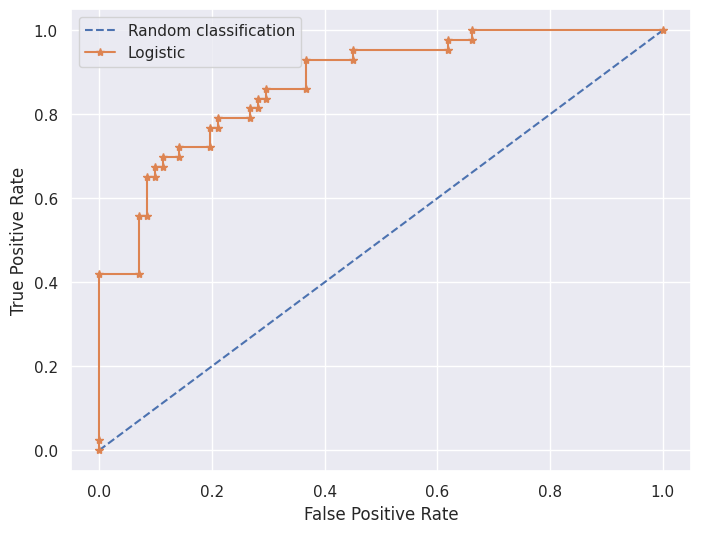

In [64]:
prob_test = pd.DataFrame(model_LR_rus.predict_proba(X_test))
prob_test = prob_test[1]

# generate a no skill prediction (majority class)
random_class = [0 for _ in range(len(y_test))]
rand_auc = roc_auc_score(y_test, random_class)

auc = roc_auc_score(y_test, prob_test)
print('Logistic: ROC AUC=%.3f' % (auc))

rndm_false_postv, rndm_true_postv, threshold = roc_curve(y_test, random_class)
false_positive, true_postitive, _ = roc_curve(y_test, prob_test)

plt.figure(figsize=(8, 6))
plt.plot(rndm_false_postv, rndm_true_postv, linestyle='--', label='Random classification')
plt.plot(false_positive, true_postitive, marker='*', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: ROC AUC=0.801


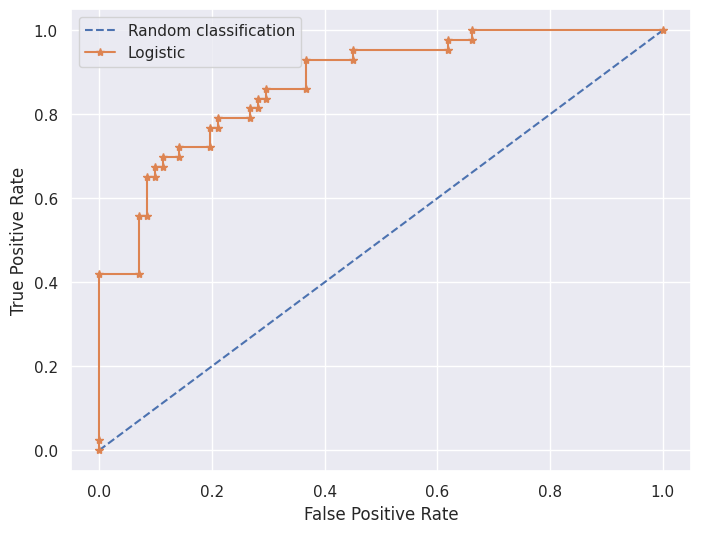

In [65]:
prob_test = pd.DataFrame(model_LR_rus.predict_proba(X_test))
prob_test = prob_test[1]

# generate a no skill prediction (majority class)
random_class = [0 for _ in range(len(y_test))]
rand_auc = roc_auc_score(y_test, random_class)

auc = roc_auc_score(y_test, prob_test, max_fpr = 0.3)
print('Logistic: ROC AUC=%.3f' % (auc))

rndm_false_postv, rndm_true_postv, threshold = roc_curve(y_test, random_class)
false_positive, true_postitive, _ = roc_curve(y_test, prob_test)

plt.figure(figsize=(8, 6))
plt.plot(rndm_false_postv, rndm_true_postv, linestyle='--', label='Random classification')
plt.plot(false_positive, true_postitive, marker='*', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Definición del punto de corte (threshold)

In [66]:
def Threshold(X = X_test, model = model_LR_rus, threshold = 0.5):
    prob_test = pd.DataFrame(model.predict_proba(X).round(3))

    prob_test.loc[prob_test[1] > threshold, 'yhat'] = 1
    prob_test.loc[prob_test[1] <= threshold, 'yhat'] = 0

    y_threshold = pd.concat([prob_test, y_test.reset_index(drop = True)], axis = 1)
    cross_threshold = pd.crosstab(y_threshold["diagnosis2"], y_threshold["yhat"], margins = True)

    print(tabulate(cross_threshold,headers = ['pred No','Pred Yes', 'All'], showindex = ['Real No','Real Yes', 'All'], tablefmt = 'fancy_grid'))

    accuracy = (cross_threshold[1][1] + cross_threshold[0][0]) / (cross_threshold['All']['All'])
    recall = cross_threshold[1][1] / (cross_threshold[1][1] + cross_threshold[0][1])
    precision = cross_threshold[1][1] / (cross_threshold[1][1] + cross_threshold[1][0])
    F_Score = 2*(precision*recall) / (precision + recall)
    print("\n")
    print("Accuracy", accuracy.round(3))
    print("Precision", precision.round(3))
    print("Recall", recall.round(3))
    print("F_Score", F_Score.round(3))
    print("\n")
    #return cross_threshold

Threshold(X_test,model_LR_rus, 0.50)

╒══════════╤═══════════╤════════════╤═══════╕
│          │   pred No │   Pred Yes │   All │
╞══════════╪═══════════╪════════════╪═══════╡
│ Real No  │        58 │         13 │    71 │
├──────────┼───────────┼────────────┼───────┤
│ Real Yes │        12 │         31 │    43 │
├──────────┼───────────┼────────────┼───────┤
│ All      │        70 │         44 │   114 │
╘══════════╧═══════════╧════════════╧═══════╛


Accuracy 0.781
Precision 0.705
Recall 0.721
F_Score 0.713




In [67]:
Threshold(X_test,model_LR_rus, 0.55)

╒══════════╤═══════════╤════════════╤═══════╕
│          │   pred No │   Pred Yes │   All │
╞══════════╪═══════════╪════════════╪═══════╡
│ Real No  │        71 │          0 │    71 │
├──────────┼───────────┼────────────┼───────┤
│ Real Yes │        26 │         17 │    43 │
├──────────┼───────────┼────────────┼───────┤
│ All      │        97 │         17 │   114 │
╘══════════╧═══════════╧════════════╧═══════╛


Accuracy 0.772
Precision 1.0
Recall 0.395
F_Score 0.567




In [68]:
Threshold(X_test,model_LR_rus, 0.45)

╒══════════╤═══════════╤════════════╤═══════╕
│          │   pred No │   Pred Yes │   All │
╞══════════╪═══════════╪════════════╪═══════╡
│ Real No  │        25 │         46 │    71 │
├──────────┼───────────┼────────────┼───────┤
│ Real Yes │         1 │         42 │    43 │
├──────────┼───────────┼────────────┼───────┤
│ All      │        26 │         88 │   114 │
╘══════════╧═══════════╧════════════╧═══════╛


Accuracy 0.588
Precision 0.477
Recall 0.977
F_Score 0.641




In [69]:
log_reg = smf.logit("diagnosis2 ~ smoothness_mean + compactness_mean", data=cancer).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.444855
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             diagnosis2   No. Observations:                  569
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                  0.3263
Time:                        15:53:37   Log-Likelihood:                -253.12
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                 5.709e-54
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.0903      0.885     -3.490      0.000      -4.826      -1.355
smoothness_

## Resumen métricas

 - Inicalmente tenemos 4 métricas para medir cómo de bien clasifica nuestro modelo: Accuracy, Precisión, Potencia y F1-Score. Cuanto más alto su valor mejor predice el modelo.

 - Cross-Validation sirve para escoger entre dos o más modelos. Se comparan y el que obtenga mejores métricas lo elegimos.

  - Calculamos la media de alguna de las 4 medidas indicadas arriba (Acuracy, Potencia, F1...) de las K subpartes en las que dividimos el conjunto de entrenamiento. Repetimos este proceso tantas veces como modelos diferentes queramos comparar
  
 - Log-Likelihood también sirve para comparar modelos, pero solo de regresión logística entre sí. Cuanto menor sea el valor mejor clasifica nuestro modelo.

- En general cuando comparamos modelos si la diferencia no es muy grande elegimos el que menos variables tenga, por ser más sencillo y, por eso, más estable en el tiempo.


